In [33]:
import os
import io
import sys
import re
import time
import math
import pickle

import numpy as np
import pandas as pd

from numpy import nan as Nan
from numpy import inf as inf
from tqdm import notebook as tqdm
from scipy.sparse import csr_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from matplotlib import ticker
from matplotlib import colors as mcolors
from random import shuffle
from data_preprocessing import *

In [37]:
def load_csv(path):
    save_path = os.path.join(os.getcwd(), path)
    open_file = open(save_path, 'rb')
    labels_df = pickle.load(open_file)
    open_file.close()
    return labels_df


dfs = []
for i in range(15):
    dfs.append(load_csv(f"groups_and_oxi_states_15_traj/df_features_step_{i}.pkl"))


In [38]:
grand_zero_columns = set()
nan_features = ['feature_13', 'feature_5', 'feature_8', 'feature_2']
for i, df in enumerate(dfs):
    dfs[i] = dfs[i].drop(['stru_traj', 'structure_A', 'structure_AM',
       'structure_CAN', 'structure_CAMN', 'structure_A40', 'structure_AM40',
       'structure_CAN40', 'structure_CAMN40'], axis = 1)
    dfs[i] = dfs[i].drop(nan_features, axis = 1)
    dfs[i], zero_columns = make_plane(dfs[i])
    grand_zero_columns.update(zero_columns)

In [39]:
for i, df in enumerate(dfs):
    dfs[i] = dfs[i].drop(grand_zero_columns, axis = 1)
    dfs[i] = dfs[i][dfs[i]['group'] != 'group_D']
    dfs[i]['is_good'] = (dfs[i]['group'] == 'group_A') | (dfs[i]['group'] == 'group_B') | (dfs[i]['group'] == 'group_E')
    dfs[i] = dfs[i].drop(['group'], axis = 1)


In [ ]:
def find_most_important_features(X, y, random_split):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=50,
        steps=6,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
    return model

In [ ]:
df = dfs[0]
X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'].astype(int))
model = find_most_important_features(X, y, random_split = 42)

In [41]:
target_color = ['lightgreen' if v == 1 else 'pink' for v in y]
traj_color = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
traj_color = list(traj_color.keys())
shuffle(traj_color)
traj_color = traj_color[:len(y)]

In [44]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(7, 7), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    return ax


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


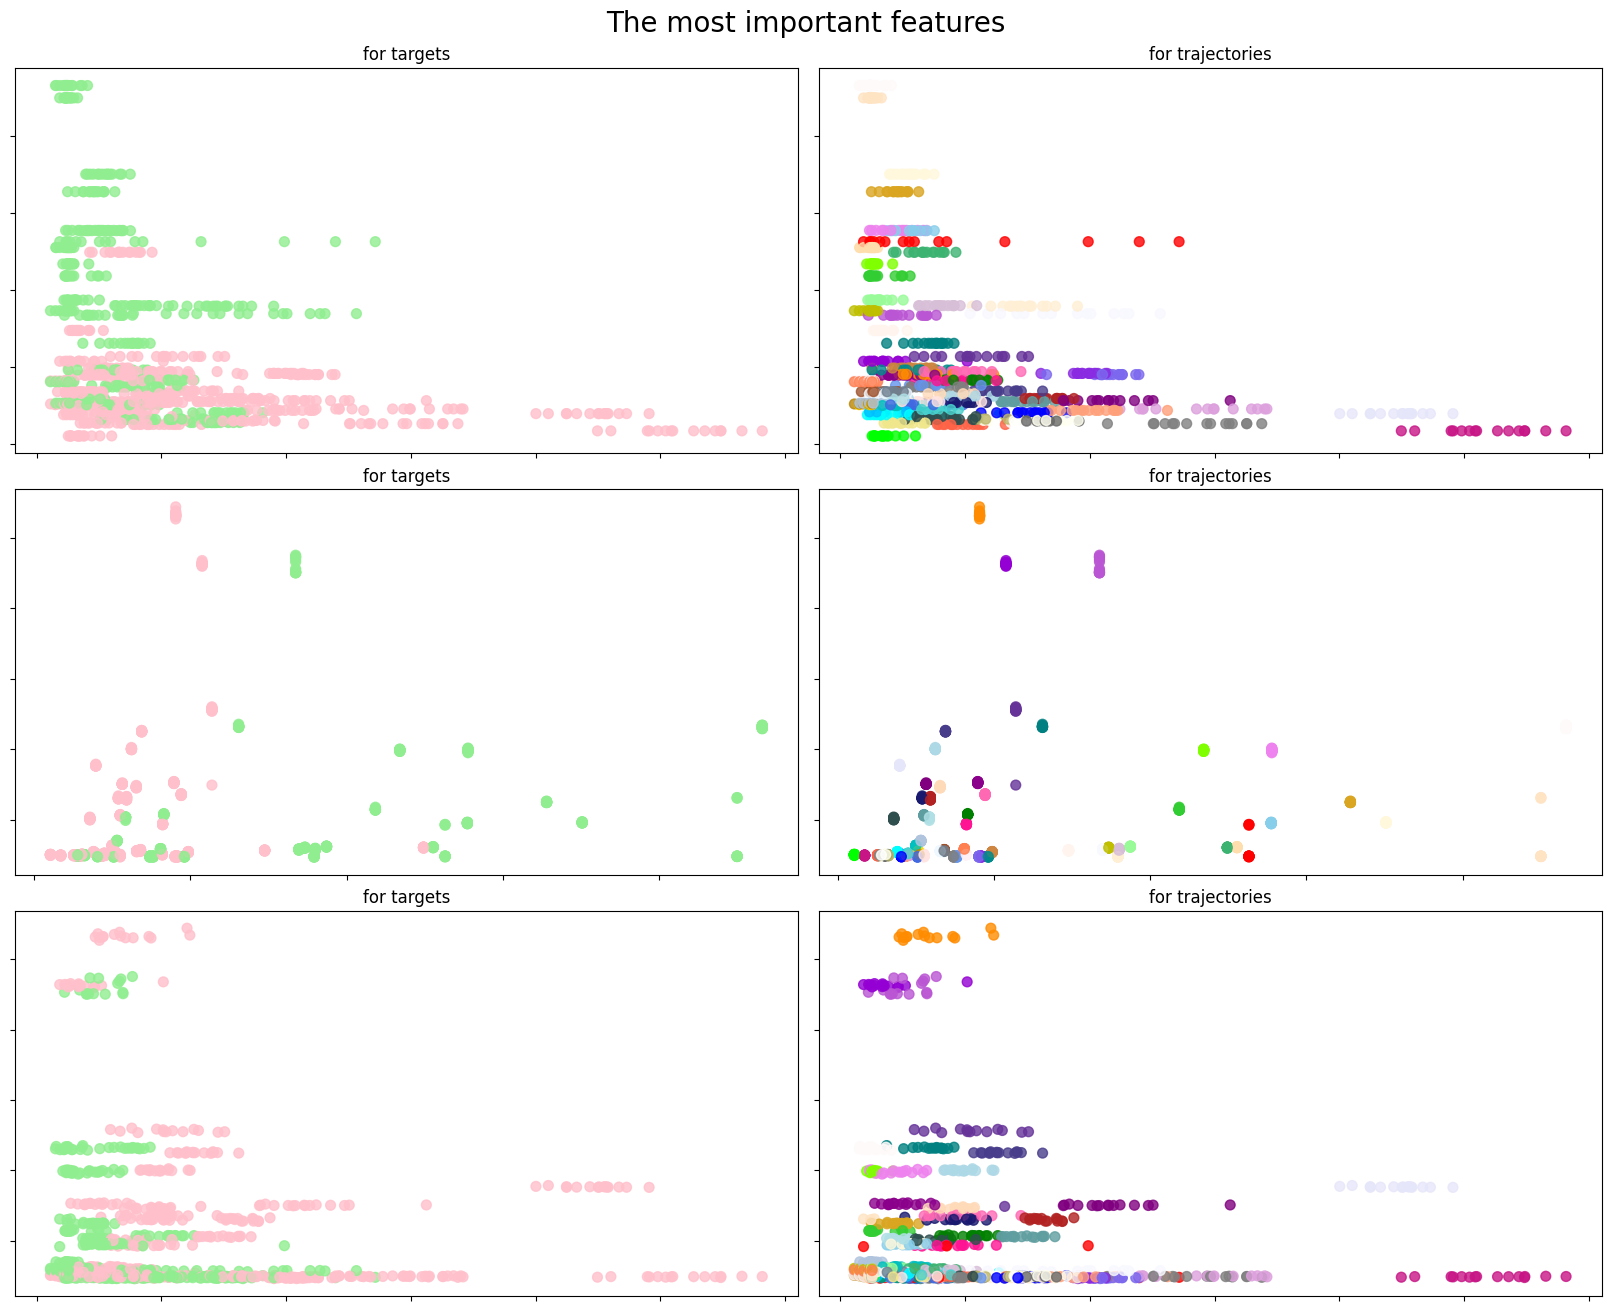

In [45]:
first_feature, second_feature, third_feature = np.argsort(model.get_feature_importance())[::-1][:3]

fig, axs = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 13), facecolor="white", constrained_layout=True
)

fig.suptitle('The most important features', fontsize=20)

for i in range(15):
    scaler = StandardScaler()
    X, y = (dfs[i].drop(['is_good', 'stru_label'], axis=1), dfs[i]['is_good'])
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict_proba(X_tr)[:, 1]
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    X_tr = np.array(X_tr)
    X_te = np.array(X_te)
    x_1 = X_tr[:, first_feature]
    x_2 = X_tr[:, second_feature]
    x_3 = X_tr[:, third_feature]
    add_2d_scatter(axs[0][0], np.array([x_2, x_1]), target_color, "for targets")
    add_2d_scatter(axs[1][0], np.array([x_1, x_3]), target_color, "for targets")
    add_2d_scatter(axs[2][0], np.array([x_2, x_3]), target_color, "for targets")

    add_2d_scatter(axs[0][1], np.array([x_2, x_1]), traj_color, "for trajectories")
    add_2d_scatter(axs[1][1], np.array([x_1, x_3]), traj_color, "for trajectories")
    add_2d_scatter(axs[2][1], np.array([x_2, x_3]), traj_color, "for trajectories")
    

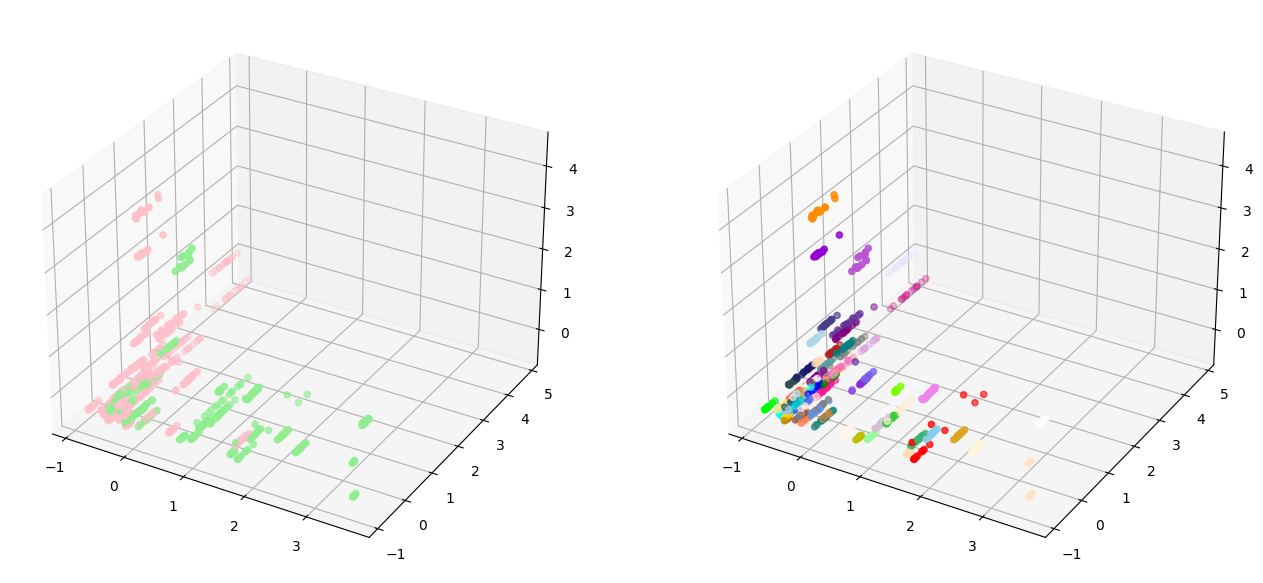

In [46]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 13), subplot_kw=dict(projection='3d')
)

for i in range(15):
    X, y = (dfs[i].drop(['is_good', 'stru_label'], axis=1), dfs[i]['is_good'])
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict_proba(X_tr)[:, 1]
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    X_tr = np.array(X_tr)
    X_te = np.array(X_te)
    colors = ['lightgreen' if v >= 0.5 else 'pink' for v in y_pred]
    axs[0].scatter3D(X_tr[:, first_feature], X_tr[:, second_feature], X_tr[:, third_feature], color = target_color) 
    axs[1].scatter3D(X_tr[:, first_feature], X_tr[:, second_feature], X_tr[:, third_feature], color = traj_color) 

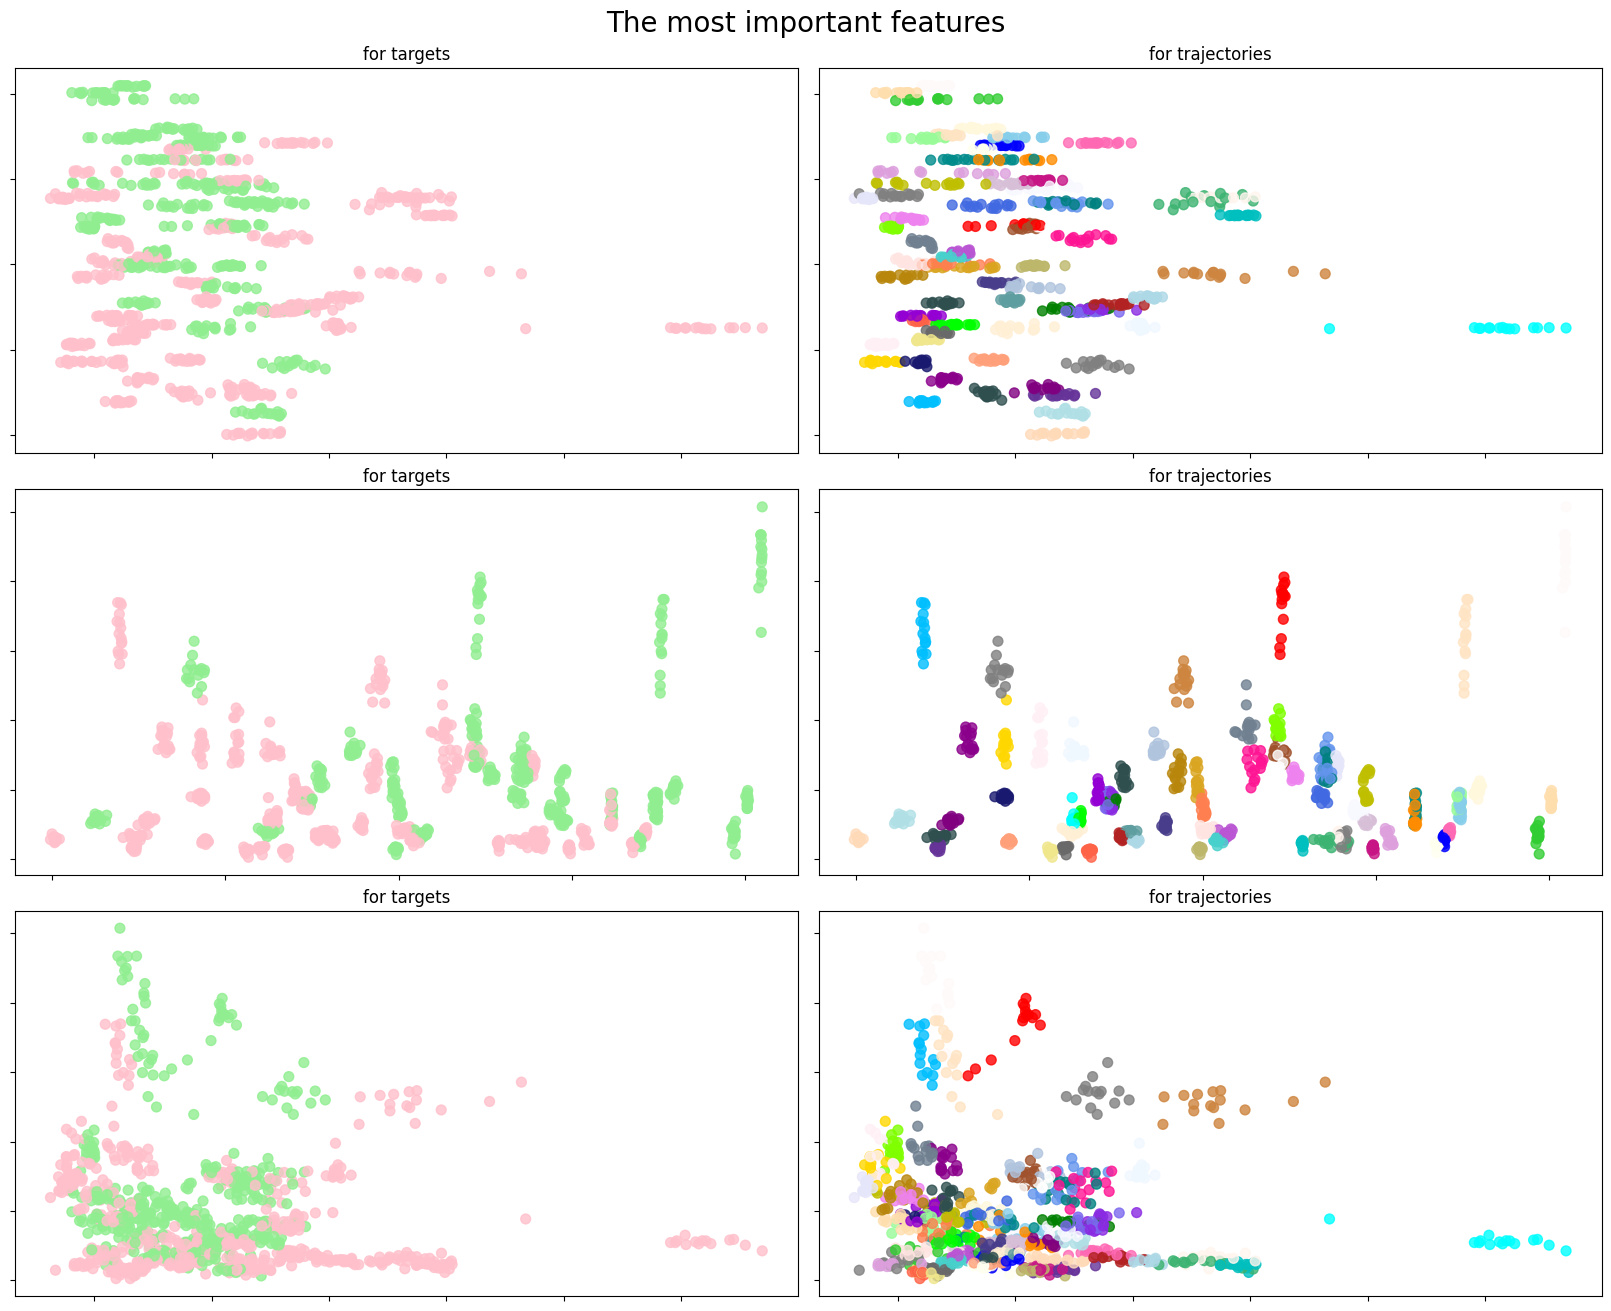

In [48]:
first_feature, second_feature, third_feature = np.argsort(model.get_feature_importance())[::-1][3:6]

fig, axs = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 13), facecolor="white", constrained_layout=True
)

fig.suptitle('The most important features', fontsize=20)

for i in range(15):
    X, y = (dfs[i].drop(['is_good', 'stru_label'], axis=1), dfs[i]['is_good'])
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict_proba(X_tr)[:, 1]
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    X_tr = np.array(X_tr)
    X_te = np.array(X_te)
    x_1 = X_tr[:, first_feature]
    x_2 = X_tr[:, second_feature]
    x_3 = X_tr[:, third_feature]
    add_2d_scatter(axs[0][0], np.array([x_2, x_1]), target_color, "for targets")
    add_2d_scatter(axs[1][0], np.array([x_1, x_3]), target_color, "for targets")
    add_2d_scatter(axs[2][0], np.array([x_2, x_3]), target_color, "for targets")

    add_2d_scatter(axs[0][1], np.array([x_2, x_1]), traj_color, "for trajectories")
    add_2d_scatter(axs[1][1], np.array([x_1, x_3]), traj_color, "for trajectories")
    add_2d_scatter(axs[2][1], np.array([x_2, x_3]), traj_color, "for trajectories")
    

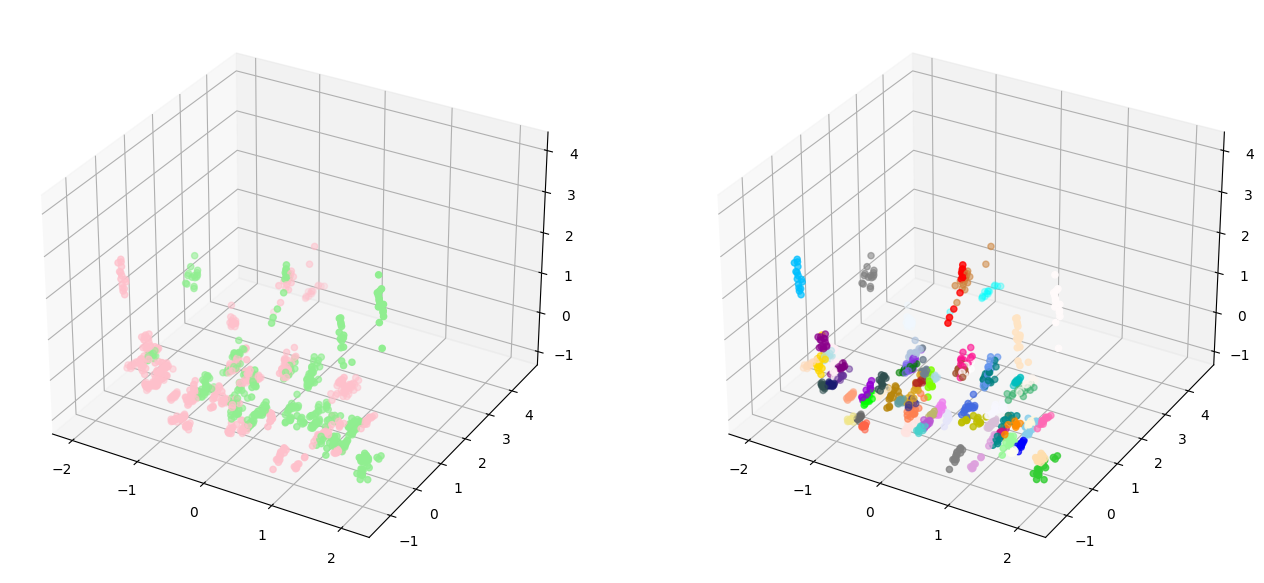

In [49]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 13), subplot_kw=dict(projection='3d')
)

for i in range(15):
    X, y = (dfs[i].drop(['is_good', 'stru_label'], axis=1), dfs[i]['is_good'])
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict_proba(X_tr)[:, 1]
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    X_tr = np.array(X_tr)
    X_te = np.array(X_te)
    colors = ['lightgreen' if v >= 0.5 else 'pink' for v in y_pred]
    axs[0].scatter3D(X_tr[:, first_feature], X_tr[:, second_feature], X_tr[:, third_feature], color = target_color) 
    axs[1].scatter3D(X_tr[:, first_feature], X_tr[:, second_feature], X_tr[:, third_feature], color = traj_color) 

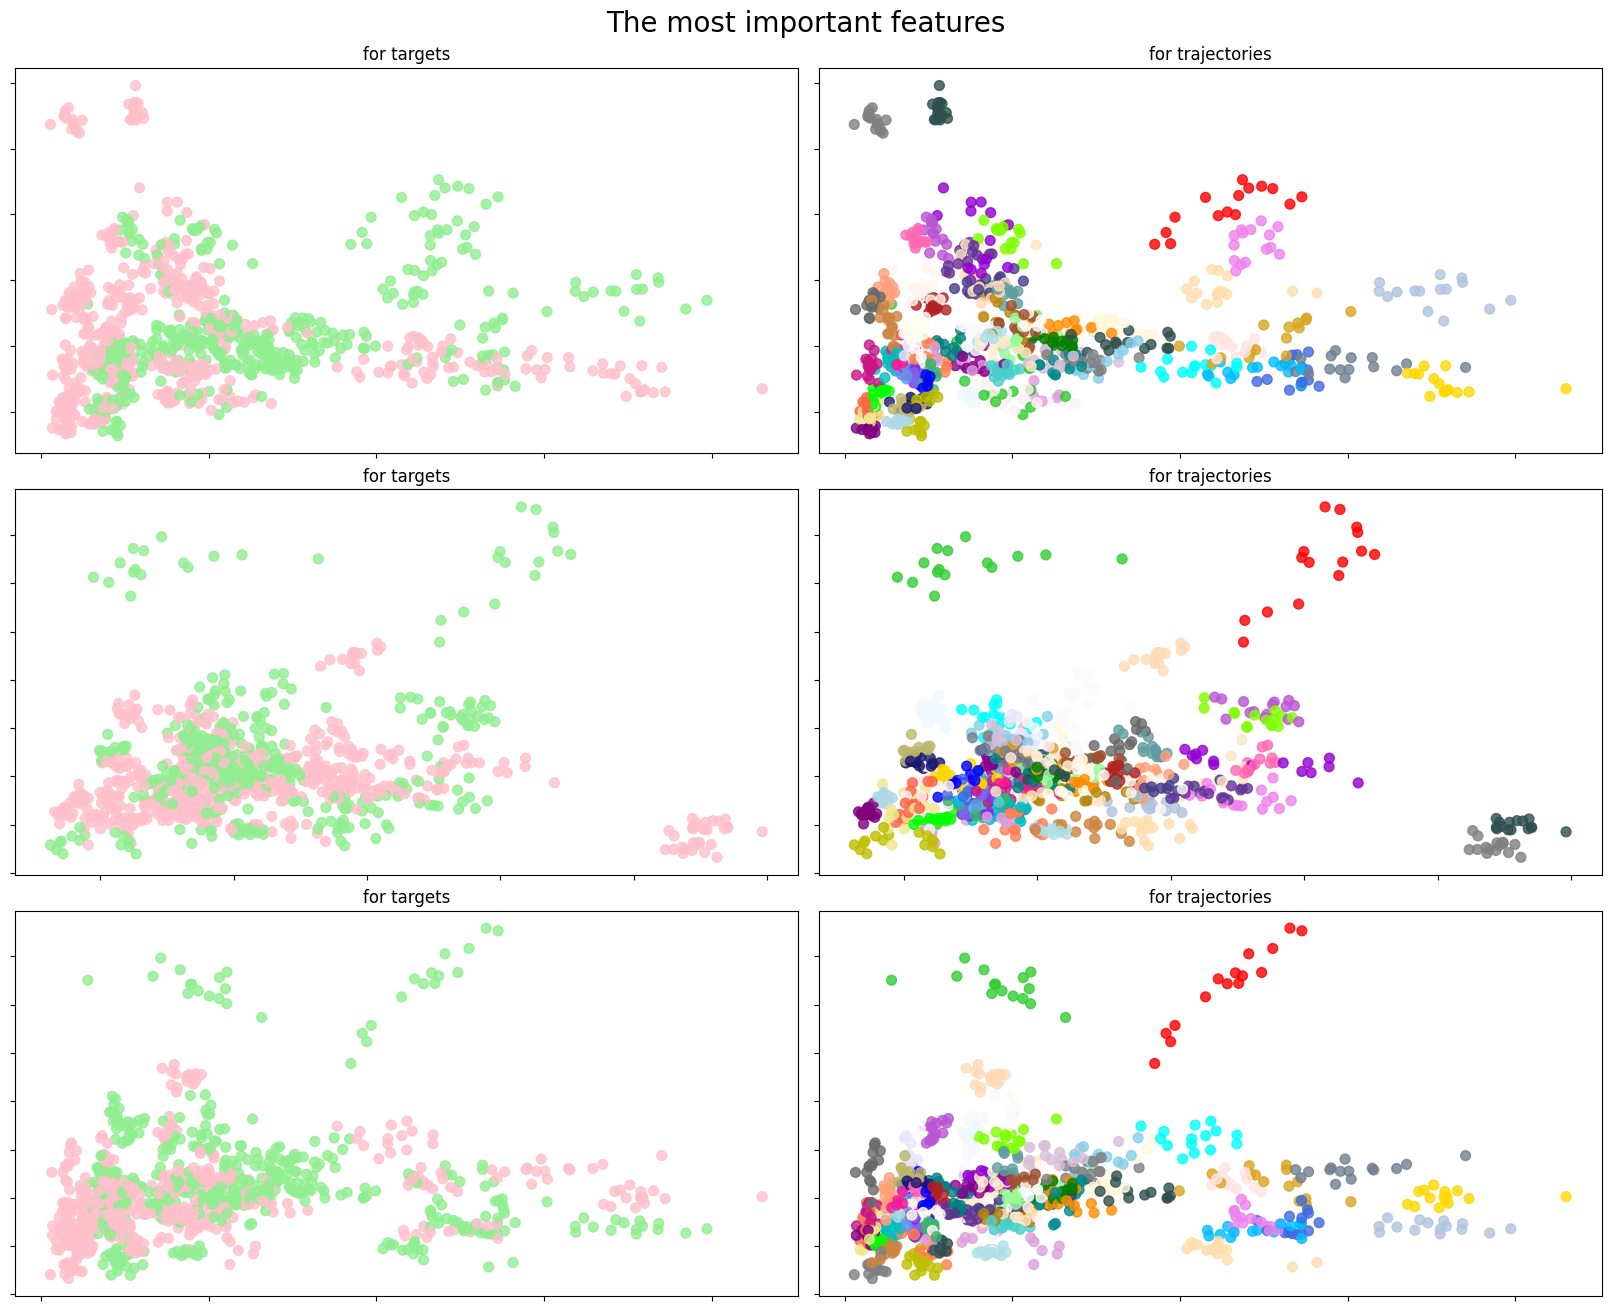

In [50]:
first_feature, second_feature, third_feature = np.argsort(model.get_feature_importance())[::-1][6:9]


fig, axs = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 13), facecolor="white", constrained_layout=True
)

fig.suptitle('The most important features', fontsize=20)

for i in range(15):
    X, y = (dfs[i].drop(['is_good', 'stru_label'], axis=1), dfs[i]['is_good'])
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict_proba(X_tr)[:, 1]
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    X_tr = np.array(X_tr)
    X_te = np.array(X_te)
    x_1 = X_tr[:, first_feature]
    x_2 = X_tr[:, second_feature]
    x_3 = X_tr[:, third_feature]
    add_2d_scatter(axs[0][0], np.array([x_2, x_1]), target_color, "for targets")
    add_2d_scatter(axs[1][0], np.array([x_1, x_3]), target_color, "for targets")
    add_2d_scatter(axs[2][0], np.array([x_2, x_3]), target_color, "for targets")

    add_2d_scatter(axs[0][1], np.array([x_2, x_1]), traj_color, "for trajectories")
    add_2d_scatter(axs[1][1], np.array([x_1, x_3]), traj_color, "for trajectories")
    add_2d_scatter(axs[2][1], np.array([x_2, x_3]), traj_color, "for trajectories")
    

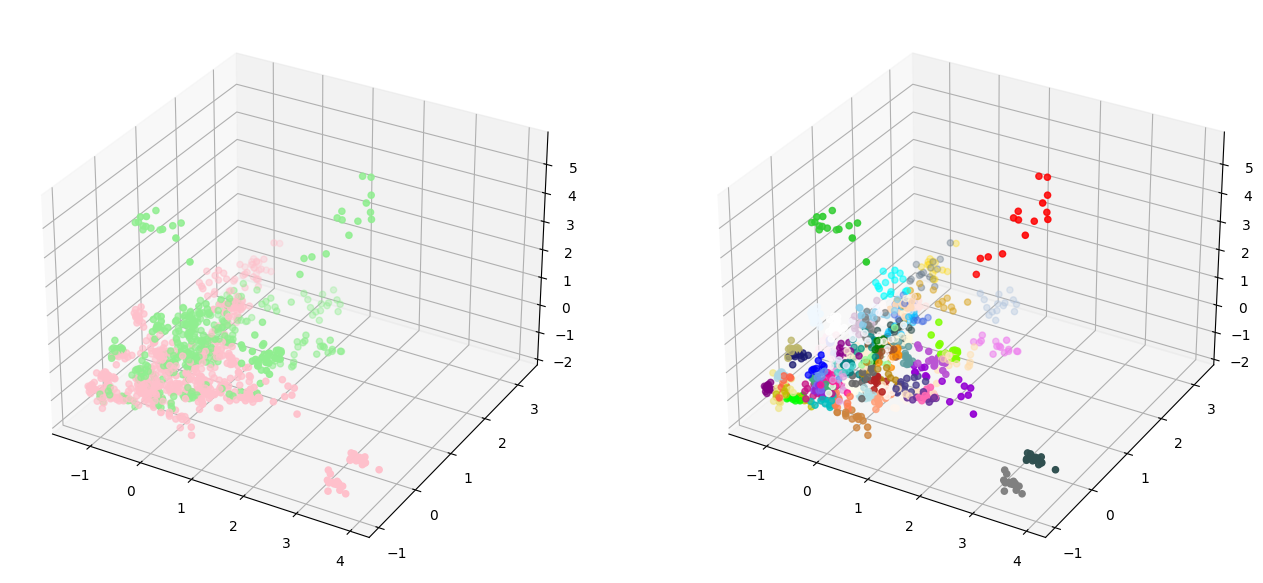

In [51]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 13), subplot_kw=dict(projection='3d')
)

for i in range(0, 15):
    X, y = (dfs[i].drop(['is_good', 'stru_label'], axis=1), dfs[i]['is_good'])
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict_proba(X_tr)[:, 1]
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    X_tr = np.array(X_tr)
    X_te = np.array(X_te)
    colors = ['lightgreen' if v >= 0.5 else 'pink' for v in y_pred]
    axs[0].scatter3D(X_tr[:, first_feature], X_tr[:, second_feature], X_tr[:, third_feature], color = target_color) 
    axs[1].scatter3D(X_tr[:, first_feature], X_tr[:, second_feature], X_tr[:, third_feature], color = traj_color) 

In [52]:
for i in range(15):
    dfs[i].to_csv(f'embeddings/embeddings_{i}.csv', header=False, index=False)